In [1]:
###### Get twitter data starts here
## Get time

In [ ]:
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [3]:
### Global Variable
### Hours/days to take into consideration
### By Default we are taking into the consideration of the past 2 day
hour = 24*2
### The time used in Twitter is greenwich time
### By default, the real time analysis
today = datetime.now()

## To replicate the result in the manuscritp, uncomment the next line
## today = datetime(2021,9, 27, 17)


In [4]:
today

datetime.datetime(2022, 7, 13, 10, 16, 21, 73809)

In [23]:
## Get time
os.system('mkdir data')


## data collected in the range
today_str_list = []
for i in range(0, hour):
    temp = today-timedelta(hours=i)
    timestr = "*"+str(temp.year)+"-"+str(temp.month).zfill(2)+"-"+str(temp.day).zfill(2)+"_"+str(temp.hour).zfill(2)+"*"
    today_str_list.append(timestr)
today_str_list

for ele in today_str_list:
    
    cmd = 'scp flu8@keeling.earth.illinois.edu:/data/cigi/twitter-data/TwitterData2021/data/'+ele+' ./data/'
    #print(cmd)
    os.system(cmd)
## Unzip data
os.system('gzip -d ./data/*.gz')


0

In [24]:
## Load chicago shapefile
shapefile = gpd.read_file("./geo/geo_export_5bb8636f-65b7-450a-8fd9-7f01027fd84b.shp")
chicago_shape = shapefile["geometry"][0]

In [84]:
## get the twitter in chicago
## City scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')[1:]
filelist

twitter_in_chicago = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    f = open(filepath)
    data = json.load(f)
    
    ## Read the data if the centroid of the twitter point polygon lies within the boundary of the city of Chicago
    for i in range(0, len(data)):
        try:
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            t = data[i]['created_at']
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((exact_loc, t, text))
            else:
                ## Twitter with a polygon bounding box
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = -1000
                lat = -1000

                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                point = Point(centroid)
                ## check if a centroid is in the bounding box of chicago
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((poly, t, text))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-25_20-12-57.json
./data/250000-tweets-2021-09-25_22-39-35.json
./data/250000-tweets-2021-09-26_01-46-49.json
./data/250000-tweets-2021-09-26_04-56-08.json
./data/250000-tweets-2021-09-26_07-36-30.json
./data/250000-tweets-2021-09-26_09-39-36.json
./data/250000-tweets-2021-09-26_11-29-11.json
./data/250000-tweets-2021-09-26_13-18-44.json
./data/250000-tweets-2021-09-26_15-10-52.json
./data/250000-tweets-2021-09-26_17-16-06.json
./data/250000-tweets-2021-09-26_19-43-23.json
./data/250000-tweets-2021-09-26_22-13-26.json
./data/250000-tweets-2021-09-27_01-25-20.json
./data/250000-tweets-2021-09-27_04-55-04.json
./data/250000-tweets-2021-09-27_07-37-52.json
./data/250000-tweets-2021-09-27_09-50-17.json
./data/250000-tweets-2021-09-27_11-54-29.json
./data/250000-tweets-2021-09-27_14-02-02.json
./data/250000-tweets-2021-09-27_16-14-54.json


In [86]:
print ("There are in total "+str(len(twitter_in_chicago))+" geo-tagged Twitter Collected in Chicago")

There are in total 21525 geo-tagged Twitter Collected in Chicago


In [104]:
twitter_in_chicago[0]

([[-87.940033, 41.644102],
  [-87.940033, 42.023067],
  [-87.523993, 42.023067],
  [-87.523993, 41.644102]],
 'Sat Sep 25 22:48:58 +0000 2021',
 'I cannot fathom people yelling “get in the weeds” and other negative sentiments at the Euro players @rydercup. Chee… https://t.co/gh39OfxkzA')

In [106]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass

In [107]:
## Iterate through all twitter data in chicago

d_twitter = []
for i in range(0, len(twitter_in_chicago)):
    loc = twitter_in_chicago[i][0]
    t = twitter_in_chicago[i][1]
    text = twitter_in_chicago[i][2]
    res = re.findall(r'\w+', text.lower())
    val = 0
    for word in res:
        if word in dict_word.keys():
            val = val + dict_word[word]
    ## remove weather-irrelevant twitter
    ## if none of the word in the heat dictionary show up 
    if (val!=0):
        d_twitter.append((loc, t, val))

In [112]:
print("There are "+str(len(d_twitter))+" weather-related Twitter in Chicago")

There are 772 weather-related Twitter in Chicago


In [140]:
m_dic = {}
m_dic['Jan'] = 1
m_dic['Feb'] = 2
m_dic['Mar'] = 3
m_dic['Apr'] = 4
m_dic['May'] = 5
m_dic['Jun'] = 6
m_dic['Jul'] = 7
m_dic['Aug'] = 8
m_dic['Sep'] = 9
m_dic['Oct'] = 10
m_dic['Nov'] = 11
m_dic['Dec'] = 12

In [153]:
## Find the time difference between the current time and the Twitter post time
weather_related_twitter = []
for twitter in d_twitter:
    loc = twitter[0]
    t = twitter[1].split()
    val = twitter[2]
    month = m_dic[t[1]]
    day = int(t[2])
    year = int(t[5])
    hour = int(t[3].split(":")[0])
    minute = int(t[3].split(":")[1])
    twitter_t = datetime(year, month, day, hour, minute)
    diff_minute = abs(twitter_t - today).total_seconds() / 60.0
    weather_related_twitter.append((loc, diff_minute, val))

In [235]:
## Generate raster based about 1 km spatial resoltuion 
## one Degree latitude = 111 km
## In chicago, where latitude = 41.881832, one Degree longitude = 82 km
## We use this estimation for the following ananlsis
## This work as the city of Chicago is small
lat_start = 41.05
lon_start = -87.96

incre_lat = 1/111
incre_lon = 1/82

lat_end = 42.05
lon_end = -87.5

raster = []

lat = lat_start

while(lat<lat_end):
    lon = lon_start
    while(lon<lon_end):
        curr_point = Point(lon, lat)
        if (curr_point.within(chicago_shape)):
            raster.append([lon, lat])
        lon = lon+incre_lon
    lat = lat+incre_lat


In [236]:
len(raster)

593

In [208]:
## Generate a random point from a polygon
import random

def generate_random(number, polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [221]:
## Function to generate random location twitter
## For monte caro experiment
## Enable exact and poly if you want to see how many twitter has exact location and how many comes with a polygon
#exact = 0
#poly = 0
def generate_random_loc(weather_related_twitter):
    random_loc_twitter = []
    for ele in weather_related_twitter:
        loc = ele[0]
        point = 0
        #print(loc)
        if (type(loc)==Point):
            ## exact location extracted
            point = loc
            #exact = exact+1
        else:
            ## Select a random point from a multi-polygon
            point = generate_random(1, Polygon(loc))
            #poly = poly+1
        random_loc_twitter.append([point, ele[2]])
    return random_loc_twitter

In [263]:
## Set seed for reproducibility
## This may take a while

d_final = {}

for i in range(0, 100):
    ## try 100 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for ele in raster:
        lon = ele[0]
        lat = ele[1]
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down
        
        key = (ele[0],ele[1])
        if (key not in d_final.keys()):
            d_final[key]=[rt]
        else:
            d_final[key].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9
current 10
current 11
current 12
current 13
current 14
current 15
current 16
current 17
current 18
current 19
current 20
current 21
current 22
current 23
current 24
current 25
current 26
current 27
current 28
current 29
current 30
current 31
current 32
current 33
current 34
current 35
current 36
current 37
current 38
current 39
current 40
current 41
current 42
current 43
current 44
current 45
current 46
current 47
current 48
current 49
current 50
current 51
current 52
current 53
current 54
current 55
current 56
current 57
current 58
current 59
current 60
current 61
current 62
current 63
current 64
current 65
current 66
current 67
current 68
current 69
current 70
current 71
current 72
current 73
current 74
current 75
current 76
current 77
current 78
current 79
current 80
current 81
current 82
current 83
current 84
current 85
current 86
current 87
current 88
current 89
current 90
current 9

In [265]:
heat_exposure_map = {}
for key in d_final.keys():
    ## Get the average hot exposure
    heat_exposure_map[key] = np.mean(d_final[key])


In [267]:
## nomalization to 0-1
mn = min(heat_exposure_map.values())
mx = max(heat_exposure_map.values())
for key in heat_exposure_map.keys():
    norm = (heat_exposure_map[key]-mn)/(mx-mn)
    heat_exposure_map[key] = norm

In [270]:
## write it as output
import csv
!mkdir output
with open('./output/heat_exposure.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in heat_exposure_map.items():
        writer.writerow([key[0], key[1], value])

In [272]:
## High spatial resolution map is generated for visualization with tools: Kelper

In [276]:
## Integrate into census tract level
chicago = gpd.read_file("./Census_tract/geo_export_dc0b9c70-c036-4bcc-a602-8e9b9d36ea9f.shp")

In [293]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [308]:
d_final_census_track = {}

for i in range(0, 100):
    ## try 100 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for index, row in chicago.iterrows():
        key = index
        ele = row['geometry'] 
        lon = ele.centroid.x
        lat = ele.centroid.y
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down

        if (key not in d_final_census_track.keys()):
            d_final_census_track[index]=[rt]
        else:
            d_final_census_track[index].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9
current 10
current 11
current 12
current 13
current 14
current 15
current 16
current 17
current 18
current 19
current 20
current 21
current 22
current 23
current 24
current 25
current 26
current 27
current 28
current 29
current 30
current 31
current 32
current 33
current 34
current 35
current 36
current 37
current 38
current 39
current 40
current 41
current 42
current 43
current 44
current 45
current 46
current 47
current 48
current 49
current 50
current 51
current 52
current 53
current 54
current 55
current 56
current 57
current 58
current 59
current 60
current 61
current 62
current 63
current 64
current 65
current 66
current 67
current 68
current 69
current 70
current 71
current 72
current 73
current 74
current 75
current 76
current 77
current 78
current 79
current 80
current 81
current 82
current 83
current 84
current 85
current 86
current 87
current 88
current 89
current 90
current 9

In [311]:
heat_exposure_map_census_track = {}
for key in d_final_census_track.keys():
    ## Get the average hot exposure
    heat_exposure_map_census_track[key] = np.mean(d_final_census_track[key])

In [313]:
## nomalization to 0-1
mn = min(heat_exposure_map_census_track.values())
mx = max(heat_exposure_map_census_track.values())
for key in heat_exposure_map_census_track.keys():
    norm = (heat_exposure_map_census_track[key]-mn)/(mx-mn)
    heat_exposure_map_census_track[key] = norm

In [314]:
heat_exposure_map_census_track

{0: 0.3495229281579091,
 1: 0.30456058856279866,
 2: 0.2540642886803625,
 3: 0.31418855258034517,
 4: 0.3843080094437474,
 5: 0.412561163235994,
 6: 0.3344550354217313,
 7: 0.31443736729090793,
 8: 0.3006070075437512,
 9: 0.2095743563106365,
 10: 0.2318466761223389,
 11: 0.2919272614242815,
 12: 0.3018827401036465,
 13: 0.32664670435767607,
 14: 0.2763168823786423,
 15: 0.2965778876677752,
 16: 0.3775114413684784,
 17: 0.4718708989916515,
 18: 0.28892582634373765,
 19: 0.3051376234487568,
 20: 0.30638469787543515,
 21: 0.28495878946649006,
 22: 0.2967375797872618,
 23: 0.2816211255069365,
 24: 0.23063847860961884,
 25: 0.2715924506077178,
 26: 0.31018229393693436,
 27: 0.29202739522791277,
 28: 0.2989073285006192,
 29: 0.28518965248523087,
 30: 0.29635019681988756,
 31: 0.25994685219509295,
 32: 0.32406700735995175,
 33: 0.2627514666292453,
 34: 0.325767745706993,
 35: 0.35181537231684573,
 36: 0.3583803081156463,
 37: 0.27069770571547747,
 38: 0.46822411708968215,
 39: 0.4670501402527

In [316]:
chicago["he_val"]=list(heat_exposure_map_census_track.values())

In [317]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,he_val
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",0.349523
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.304561
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",0.254064
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.314189
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.384308
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.445870
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.399139
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.312587
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",0.322456


In [318]:
chicago.to_file("./output/census_tract_heat_exposure.shp")

In [323]:
with open('./output/census_tract_heat_exposure.json', 'w') as f:
        f.write(chicago.to_json())

<AxesSubplot:>

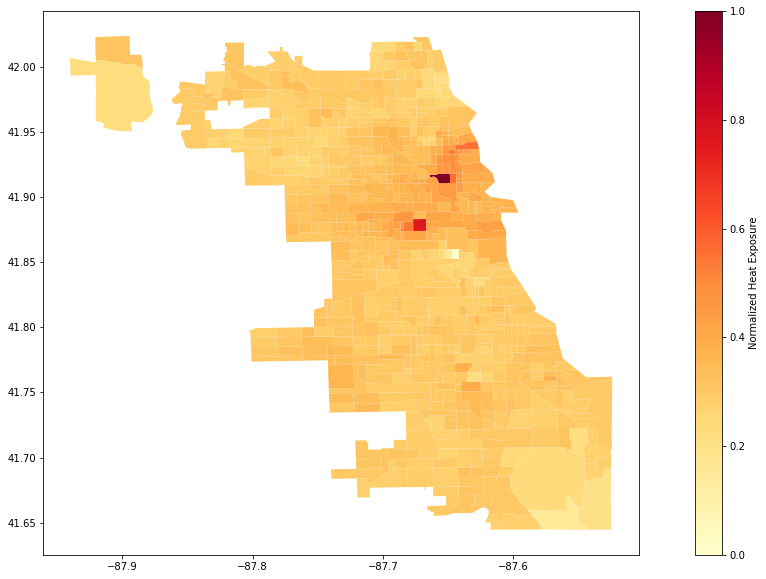

In [327]:
## Creating Choropleth Map with geopandas 
chicago.plot(column = 'he_val', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

In [ ]:
## remove all data
## Uncomment the next line if you want to remove all the Twitter data
## os.system('rm -rf data')